In [338]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [340]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [81]:
import parse_inputs

from pathlib import Path

import numpy as np
import pandas as pd
from pandas_plink import read_plink

from sklearn import linear_model
from sklearn.svm import SVR

from ggplot import *
PATH=Path('ddat/crowdAI/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

# Data load

X is genotype and gender , y is height

### Taizhao data


Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.01s/it]


all samples 2747 male 989 female 1758


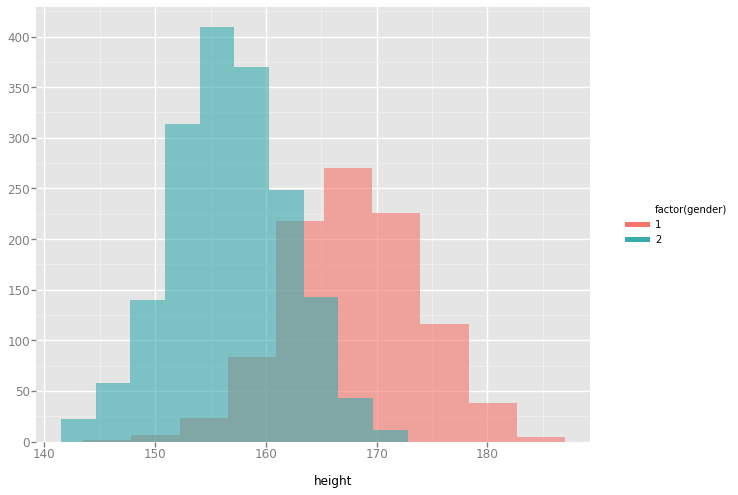

<ggplot: (8771491070959)>

In [797]:
(tz_bim,tz_fam,tz_bed) = read_plink('ddat/crowdAI/all2964/bin_final_strand')
tz_f_meta = pd.read_csv(PATH/'TZ14_height_f_v2.csv')
tz_m_meta = pd.read_csv(PATH/'TZ14_height_m_v2.csv')
tz_meta = tz_m_meta.append(tz_f_meta,ignore_index=True)
print("all samples",len(tz_meta),'male',len(tz_m_meta),'female',len(tz_f_meta))
ggplot( aes(x='height',fill='factor(gender)'),data=tz_meta) +\
    geom_histogram(alpha=0.6)

### Opensnp data

Training data


Mapping files: 100%|██████████| 3/3 [00:13<00:00,  5.97s/it]


opensnp training data 783


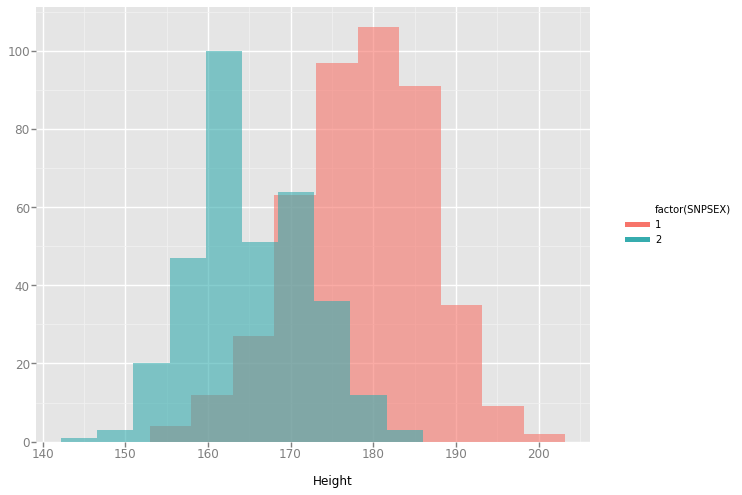

<ggplot: (-9223363265899739483)>

In [803]:
(os_bim, os_fam, os_bed) = read_plink('ddat/crowdAI/OpenSNP_train')
os_meta = pd.read_csv(PATH/'opensnp_metadat.csv',index_col=0)
os_meta = os_meta.loc[os_meta.SNPSEX>0,]
print('opensnp training data',len(os_meta))
ggplot( aes(x='Height',fill='factor(SNPSEX)'),data=os_meta) +\
    geom_histogram(alpha=0.6)

Test data

In [804]:
os_plink_test = read_plink('ddat/crowdAI/OpenSNP_test')
os_meta_test = pd.read_csv(PATH/'opensnp_trianandtest_metadata.csv',index_col=0)
os_meta_test=os_meta_test.loc[[int(x) for x in list(os_plink_test[1].iid)]]
#check iid and gender
#sum(os_meta_test.IID.eq([int(x) for x in list(os_plink_test[1].iid)])),len(os_meta_test)
#sum(os_meta_test.SNPSEX>0),sum(os_meta_test.SNPSEX.isna())
print('opensnp test data',len(os_meta_test),'male',sum(os_meta_test.SNPSEX==1))


Mapping files: 100%|██████████| 3/3 [00:12<00:00,  5.62s/it]


opensnp test data 137 male 78


# Data Cleaning 

### Meta data integration

all train and val samples 3530 tz 2747 os 783 male 1435


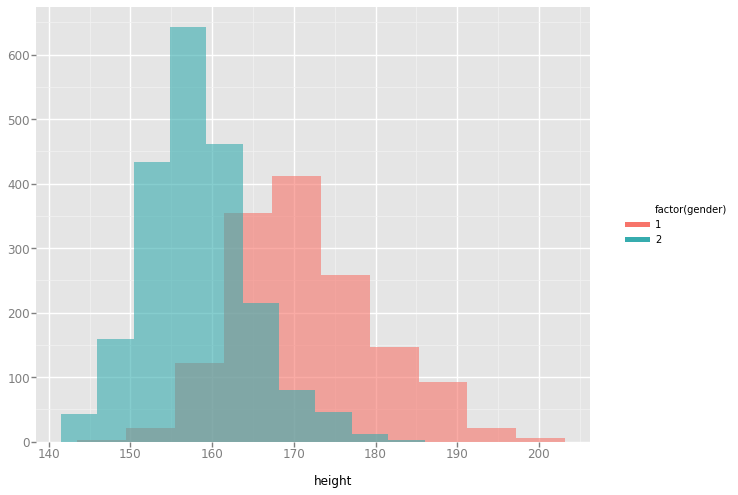

<ggplot: (-9223363265986542837)>

In [805]:
new_os_meta=os_meta.iloc[:,[1,7,0,4,3]]
tz_meta=tz_meta.iloc[:,0:5]
new_os_meta.columns=tz_meta.columns
all_meta = tz_meta.append(new_os_meta,ignore_index=True)
print('all train and val samples',len(all_meta),'tz',len(tz_meta),'os',len(new_os_meta),'male',sum(all_meta.gender==1))

ggplot( aes(x='height',fill='factor(gender)'),data=all_meta) +\
    geom_histogram(alpha=0.6)

In [126]:
all_meta.to_csv(TMP_PATH/'tz_and_os_meta.csv')

## get genotype  

get common genotype with top 1996 list  >>>628

In [806]:
common_snp = set(parse_inputs.snp_list_1996).intersection(*(tz_bim.snp,os_bim.snp))
len(common_snp)

628

common snp index in tz and os train data

In [807]:
tz_snp1996_index = [i for i,x in enumerate(tz_bim.snp) if x in common_snp]
os_snp1996_index = [i for i,x in enumerate(os_bim.snp) if x in common_snp]
len(tz_snp1996_index),len(os_snp1996_index)

(628, 628)

samples match with meta data

In [809]:
all_meta = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)
tz_sample_index = [i for i,x in enumerate(tz_fam.iid) if x in list(all_meta.ChipID)]
os_sample_index = [i for i,x in enumerate(os_fam.iid) if x in list(all_meta.ChipID)]
len(tz_sample_index),len(os_sample_index)

(2747, 783)

#### get sub snp and samples

In [813]:
def plink_slice(p,pb=None,pf=None):
    """
    p: list of bim, fam, bed
    pb: index of bim
    pf: index of fam
    """
    (bim,fam,bed)=p
    if pb:
        bim = bim.iloc[pb]
        bed = bed[pb,:]
    if pf:
        fam = fam.iloc[pf]
        bed = bed[:,pf]
    return(bim,fam,bed)

In [814]:
tz_sub=plink_slice((tz_bim,tz_fam,tz_bed),tz_snp1996_index,tz_sample_index)
os_sub=plink_slice((os_bim,os_fam,os_bed),os_snp1996_index,os_sample_index)

#### get sub test sample

In [821]:
os_sub_test=plink_slice(os_plink_test,os_snp1996_index)
#check test sample and training sample having same snps
print(os_sub_test[0].shape,os_sub[0].shape)
print(os_sub_test[0].iloc[:,0:4].equals(os_sub[0].iloc[:,0:4]))
#but some of them have opposite a0 and a1
sum([x==y for x,y in zip(os_sub_test[0].a0,os_sub[0].a0)])

(628, 7) (628, 7)
True


601

## align a0 and a1 to a ref. (reverse 0 and 2 genotype)

In [822]:
def align_a0_a1(refp,p):
    refbim=refp[0].reset_index(drop=True)
    pbim=p[0].reset_index(drop=True)
    if refbim.snp.equals(pbim.snp) and refbim.pos.equals(pbim.pos):
        diff_idx=[x!=y for x,y in zip(refbim.a0,pbim.a0)]
        if all([x==y for x,y in zip(refbim.a0[diff_idx],pbim.a1[diff_idx])]):
            pbed = pd.DataFrame(p[2].compute())
            tmp = pbed.copy()
            #tmp1 = pbed.copy()
            tmp = tmp.iloc[diff_idx,:]
            #tmp1 = tmp1.iloc[diff_idx,:]
            tmp.replace([0,2],[2,0],inplace=True)
            pbed.loc[diff_idx]=tmp
            return pbed
        else:
            print("can't alignment")
    else:
        print('error happens in align')

align genotype of opensnp traing and test data to taizhao

In [830]:
os_sub_align = align_a0_a1(tz_sub,os_sub)
os_sub_test_align = align_a0_a1(tz_sub,os_sub_test)

## Merge training data from taizhou and opensnp 

In [831]:
all_bim = tz_sub[0]
all_fam = tz_sub[1].append(os_sub[1])
#row sample and column snps
all_bed_T= pd.DataFrame(tz_sub[2].compute()).T.append(os_sub_align.T)
all_bim.shape,all_fam.shape,all_bed_T.shape

((628, 7), (3530, 7), (3530, 628))

In [832]:
all_bim.to_pickle(TMP_PATH/'all_bim.pk')

In [833]:
all_fam.to_pickle(TMP_PATH/'all_fam.pk')

In [834]:
all_bed_T.to_pickle(TMP_PATH/'all_bed_T.pk')

# Build Model

## Data Prepare

In [874]:
X = all_bed_T
X['gender'] = pd.Series(list(all_meta.gender),index=X.index)
X.fillna(-1,inplace=True)
y = all_meta.height

df_test = os_sub_test_align.T
df_test['gender']=pd.Series(list(os_meta_test.SNPSEX[[int(x) for x in list(os_plink_test[1].iid)]]),index=df_test.index)
#Replace nan values in the training and testing set with an arbitrary number (-1)
df_test.fillna(-1,inplace=True)

## Linear Model

In [844]:
from sklearn import linear_model
import crowdai

In [893]:
#Load training data
x_train = X
y_train = y
x_test = df_test

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[5:11:05<?]  ?% /s] A

CrowdAI.Event.Job.ENQUEUED : 704e24b0-0359-4591-9619-34dad214ad33



          
  0% |          |[5:11:06<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 704e24b0-0359-4591-9619-34dad214ad33



          
  0% |          |[5:11:06<?]  ?% /s] A
100% |██████████|[00:01<00:00]  98.44% /s] 
          
  0% |          |[5:11:06<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (704e24b0-0359-4591-9619-34dad214ad33) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.29995823927 ; MSE : 71.1627329757
CrowdAI.Event.Job.COMPLETE : 704e24b0-0359-4591-9619-34dad214ad33	   🍺 


### Linear model (gender)

In [892]:
#Load training data
x_train = X['gender'].reshape(3530,1)
y_train = y
x_test = df_test['gender'].reshape(137,1)

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED
CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



  0% |          |[00:00<?]  ?% /s] 
          
  0% |          |[5:10:44<?]  ?% /s] A

CrowdAI.Event.Job.ENQUEUED : 41c72906-3c82-4426-bb15-1cb29ddcc896



          
  0% |          |[5:10:44<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 41c72906-3c82-4426-bb15-1cb29ddcc896



          
  0% |          |[5:10:45<?]  ?% /s] A
100% |██████████|[00:01<00:00]  76.67% /s] 
          
  0% |          |[5:10:45<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (41c72906-3c82-4426-bb15-1cb29ddcc896) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.186633941666 ; MSE : 120.627252641
CrowdAI.Event.Job.COMPLETE : 41c72906-3c82-4426-bb15-1cb29ddcc896	   🍺 


### Linear model for os data

In [891]:
#Load training data
x_train = X.iloc[2747:3530,]
y_train = y.iloc[2747:3530,]
x_test = df_test

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[5:09:36<?]  ?% /s] A

CrowdAI.Event.Job.ENQUEUED : 59b47e40-647e-4a27-a4a4-89883976bad4



          
  0% |          |[5:09:36<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 59b47e40-647e-4a27-a4a4-89883976bad4



          
  0% |          |[5:09:37<?]  ?% /s] A
100% |██████████|[00:00<00:00]  106.33% /s] 
          
  0% |          |[5:09:37<?]  ?% /s] 3% /s] 


CrowdAI.Event.Job.INFO : (59b47e40-647e-4a27-a4a4-89883976bad4) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.56370431417e+22 ; MSE : 2.60613317337e+24
CrowdAI.Event.Job.COMPLETE : 59b47e40-647e-4a27-a4a4-89883976bad4	   🍺 


In [890]:
#Load training data
x_train = X.iloc[2747:3530,]
y_train = y.iloc[2747:3530,]
x_test = df_test

x_train = x_train['gender'].reshape(len(x_train),1)
y_train = y_train
x_test = df_test['gender'].reshape(137,1)

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[5:06:45<?]  ?% /s] A

CrowdAI.Event.Job.ENQUEUED : 79558d20-f4a2-42ec-84cf-a30cfddc1b22



          
  0% |          |[5:06:45<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 79558d20-f4a2-42ec-84cf-a30cfddc1b22



          
  0% |          |[5:06:46<?]  ?% /s] A
100% |██████████|[00:01<00:00]  82.88% /s] 
          
  0% |          |[5:06:46<?]  ?% /s] % /s] 


CrowdAI.Event.Job.INFO : (79558d20-f4a2-42ec-84cf-a30cfddc1b22) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.420750671304 ; MSE : 58.8835804044
CrowdAI.Event.Job.COMPLETE : 79558d20-f4a2-42ec-84cf-a30cfddc1b22	   🍺 


## Sample seperation

3530 3177


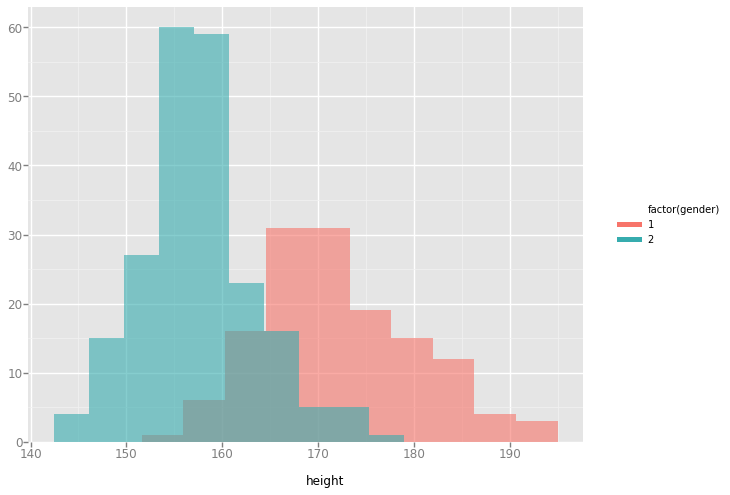

<ggplot: (-9223363265464664120)>

In [960]:
samp_size=len(all_meta)
#train_ratio = 0.75
train_ratio = 0.9
train_size = int(samp_size * train_ratio)

import random
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
ggplot( aes(x='height',fill='factor(gender)'),data=all_meta.loc[val_idx]) +\
    geom_histogram(alpha=0.6)

## Random Forest

In [961]:
from sklearn.ensemble import RandomForestRegressor
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, y)

m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn)

In [966]:
preds = m.predict(val)

In [967]:
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_

(0.9277694955569459, 0.644941436241582, 0.5615026093080486)

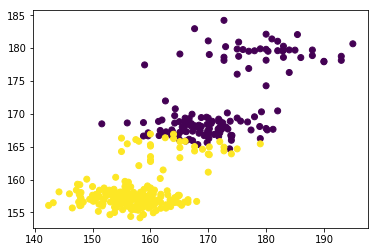

In [968]:
plt.scatter(y_val,preds,c=list(val[:,628]), marker='o')

In [971]:
heights = m.predict(df_test).tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


          
  0% |          |[00:21<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : d1f5d719-5850-4f04-8f9f-945ccdbe5cd9


          
  0% |          |[00:21<?]  ?% /s] 
  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : d1f5d719-5850-4f04-8f9f-945ccdbe5cd9


          
  0% |          |[00:22<?]  ?% /s] 
  0% |          |[00:01<?]  ?% /s] 
          ██████|[00:01<00:00]  94.78% /s] 
  0% |          |[00:22<?]  ?% /s] 
100% |██████████|[00:01<00:00]  94.78% /s] 


CrowdAI.Event.Job.INFO : (d1f5d719-5850-4f04-8f9f-945ccdbe5cd9) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.405400497205 ; MSE : 60.4440020847
CrowdAI.Event.Job.COMPLETE : d1f5d719-5850-4f04-8f9f-945ccdbe5cd9	   🍺 


## NN1

In [990]:
cat_vars = ['gender']
contin_vars = X.columns[:-1]

In [1005]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, X, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

In [1006]:
cat_sz = [(c, 3) for c in cat_vars]
cat_sz

[('gender', 3)]

In [1007]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(3, 2)]

In [898]:
y_range = (130,210)

In [1044]:
m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                   0, 1, [256,128,64], [0.3,0.5,0.3], y_range=y_range)

In [1045]:
m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                   0, 1, [128,64,16], [0,0.1,0.1], y_range=y_range)

In [1033]:
lr = 1e-3

In [1034]:
m.lr_find()

epoch      trn_loss   val_loss                           
    0      603.193343 637.361071



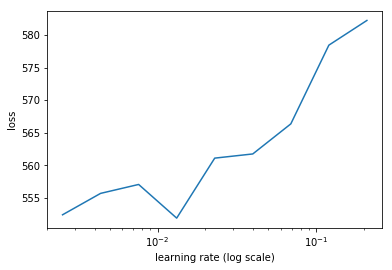

In [1035]:
m.sched.plot()

In [1036]:
m.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      334.988795 89.019218 
    1      222.420247 87.079953                           
    2      163.57229  84.658262                           



[array([84.65826])]

In [1041]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                             
    0      48.006094  43.605018 
    1      47.562058  46.185779                            
    2      46.278125  43.177474                            
    3      45.321161  42.564115                            
    4      44.615624  41.116208                            
    5      44.248996  41.173165                           
    6      44.320924  42.016006                            
    7      43.48854   43.165786                            
    8      43.175678  44.833213                           
    9      42.674917  43.38934                             



[array([43.38934])]

In [983]:
m.save('nn_model1') #R2=0.355

 24%|██▍       | 12/50 [00:00<00:00, 119.82it/s, loss=43.2]

epoch      trn_loss   val_loss                             
    0      80.888028  151.194055



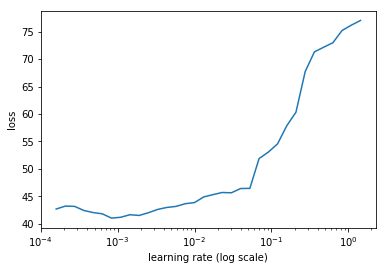

In [984]:
m.lr_find()
m.sched.plot()

In [985]:
m.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss                             
    0      50.995664  42.544632 
    1      43.480691  41.338056                            
    2      42.126355  41.464497                            



[array([41.4645])]

In [1026]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      57.78584   49.578513 
    1      53.775634  46.085355                            
    2      51.614049  43.825487                            
    3      50.302809  40.732563                            
    4      49.565065  43.737697                           
    5      47.954103  40.983987                            
    6      47.264173  38.763312                          
    7      46.305101  38.572067                            
    8      45.49319   38.968085                            
    9      46.022123  39.092998                            



[array([39.093])]

In [987]:
m.save('nn_model2') #R2=0.436

In [1046]:
m.load('nn_model2')

In [1047]:
# Predict the heights for the test set
heights = m.predict(True)
heights=heights.reshape(137)
heights = heights.tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : a78dfef4-0064-4c79-9217-5447c8d2ab21


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : a78dfef4-0064-4c79-9217-5447c8d2ab21


100% |██████████|[00:01<00:00]  96.92% /s] 


CrowdAI.Event.Job.INFO : (a78dfef4-0064-4c79-9217-5447c8d2ab21) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.43614816064 ; MSE : 57.3183488945
CrowdAI.Event.Job.COMPLETE : a78dfef4-0064-4c79-9217-5447c8d2ab21	   🍺 


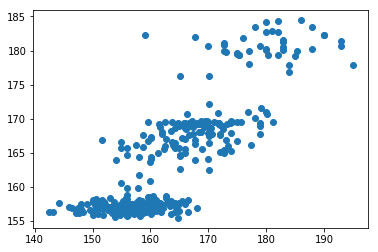

In [1049]:
plt.scatter(m.data.val_y,m.predict(), marker='o')

## NN2

In [972]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(y)
y_range = (140,200)

In [317]:
maf=pd.read_csv('../predict_height/lib/maf.csv',index_col=0)

In [321]:
sum([x in maf.index for x in all_bim.snp])

628

In [792]:
# Instantiate a linear model
x_train=X
y_train=y
x_test=df_test
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)

In [793]:
#Convert heights from np.array to a list (to ensure it is JSON serializable)
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")

heights = heights.tolist()
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 
100% |██████████|[00:00<00:00]  102.69% /s] 
          
  0% |          |[16:49<?]  ?% /s] .69% /s] 


CrowdAI.Event.Job.INFO : (bc1ef311-9598-4a6c-a9a2-cce75662d779) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.0365818509984 ; MSE : 105.373709981
CrowdAI.Event.Job.COMPLETE : bc1ef311-9598-4a6c-a9a2-cce75662d779	   🍺 


In [ ]:
import preprocess
import argparse
import models


def init_args():
    parser = argparse.ArgumentParser(description='Train and save models')
    parser.add_argument('train_datesets', help='Input csv file for training output from parse_inputs.py')
    parser.add_argument('-m', '--model', help='Train model, comma to separate', default='gbr')
    parser.add_argument('-d', '--model-dir', help='Model directory', default='models')
    parser.add_argument('-l', '--list-models', help='List available models', action='store_true')
    args = parser.parse_args()
    return args


def main():
    args = init_args()
    if args.list_models:
        print('\n'.join(models.get_model_names()))
        exit()
    m = args.model.split(',')
    dict_m = models.get_models(m)
    x, y = preprocess.load_data(args.train_datesets)
    for model_name in dict_m:
        model = dict_m[model_name]
        print('Training model %s' % model_name)
        model.fit(x, y)
        models.save_model(model, model_name, args.model_dir)
        print('Train finished, save to %s' % args.model_dir)

